In [1]:
import torch 
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from torch.autograd import Variable
from sklearn.metrics import accuracy_score
import copy
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error


In [2]:
mat_contents = scipy.io.loadmat("data_NN")

X_old = torch.zeros((3,1000),dtype=torch.float)
Y_old = torch.zeros((3,1000),dtype=torch.float)

#load data
for i in range (3):
    X_old[i] = torch.from_numpy(mat_contents['x_train'][i][:-1])
    Y_old[i] = torch.from_numpy(mat_contents['x_train'][i][1:])
    
    
X = torch.transpose(X_old.detach().clone(), 0,1)
Y = torch.transpose(Y_old.detach().clone(), 0,1)


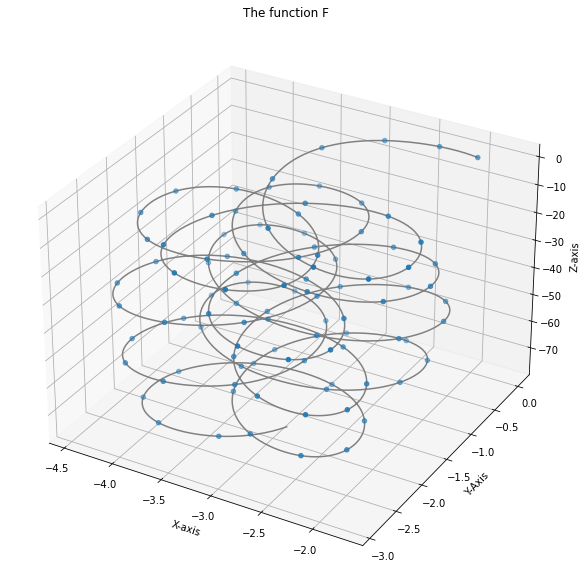

In [3]:
fig=plt.figure(figsize=(10,20))
ax = fig.gca(projection='3d')

# Data for a three-dimensional line 
x = torch.zeros(100,dtype=torch.float)
y = torch.zeros(100,dtype=torch.float)
z = torch.zeros(100,dtype=torch.float)
ax.plot3D(X_old[0].detach().numpy(), X_old[1].detach().numpy(), X_old[2].detach().numpy(), 'gray')
j = 0

for i in range (0, 1000, 10):
    x[j] = X[i][0]
    y[j] = X[i][1]
    z[j] = X[i][2]
    j+=1
    
# Data for three-dimensional scattered points
ax.scatter3D(x.detach().numpy(), y.detach().numpy(), z.detach().numpy());

ax.set_title("The function F")
ax.set(ylabel = "Y-Axis", xlabel = "X-axis", zlabel = "Z-axis")
plt.show()

In [4]:
#min-max normalization of the input at the 3 dimensions
def normalize_input(c, maximum, minimum, vector = 'false'): 
    if vector == 'true':
        c[0] = ((c[0] - minimum[0])/(maximum[0] - minimum[0]))
        c[1] = ((c[1] - minimum[1])/(maximum[1] - minimum[1]))
        c[2] = ((c[2] - minimum[2])/(maximum[2] - minimum[2]))
    
    else:
        a = torch.transpose(c,0,1)
        a[0] = ((a[0] - minimum[0])/(maximum[0] - minimum[0]))
        a[1] = ((a[1] - minimum[1])/(maximum[1] - minimum[1]))
        a[2] = ((a[2] - minimum[2])/(maximum[2] - minimum[2]))
        c = torch.transpose(a,0,1)

#transform data to the initial range for the correct comparisons with the output
def unormalize_output(c, maximum, minimum, vector = 'false'):
    if vector == 'true':
        c[0] = ((c[0]*(maximum[0] - minimum[0])) + minimum[0])
        c[1] = ((c[1]*(maximum[1] - minimum[1])) + minimum[1])
        c[2] = ((c[2]*(maximum[2] - minimum[2])) + minimum[2])
    
    else:
        a = torch.transpose(c,0,1)
    
        a[0] = ((a[0]*(maximum[0] - minimum[0])) + minimum[0])
        a[1] = ((a[1]*(maximum[1] - minimum[1])) + minimum[1])
        a[2] = ((a[2]*(maximum[2] - minimum[2])) + minimum[2])
    
        c = torch.transpose(a,0,1)
minimum = []
minimum.append(torch.min(X_old[0]).item())
minimum.append(torch.min(X_old[1]).item())
minimum.append(torch.min(X_old[2]).item())
maximum = []
maximum.append(torch.max(X_old[0]).item())
maximum.append(torch.max(X_old[1]).item())
maximum.append(torch.max(X_old[2]).item())


#Class for data passing to the DNN
class DynamicData(Dataset):
    def __init__(self, X,Y):
        self.data = list(zip(X,Y))   
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        return self.data[idx]
    

    
#normalize the input data
normalize_input(X,maximum,minimum)
dyn_dataset = DynamicData(X,Y)


#layer class with liearity and ReLU
class LinearWActivation(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearWActivation,self).__init__()
        self.f = nn.Linear(in_features,out_features)  
        self.a = nn.ReLU()
    def forward(self,x):
        return self.a(self.f(x))
        
#Model that has to be trained
class MyPredictionNet(nn.Module):
    
    def __init__(self, layers, n_features, o_features):
        super(MyPredictionNet, self).__init__()
        layers_in = [n_features] + layers
        layers_out = layers + [o_features]
        self.f = nn.Sequential(
            *[LinearWActivation(in_feats, out_feats) 
             for in_feats, out_feats in zip(layers_in,layers_out)])
        self.clf = nn.Linear(o_features, n_features)
        
    def forward(self, x):
        return self.clf(self.f(x))
    
EPOCHS = 1000
BATCH_SZ = 128
net = MyPredictionNet([], 3, 7)  

print(f"The network architecture is: \n {net}")

# define the loss function in which case is CrossEntropy Loss
criterion = nn.MSELoss() 

ETA = 1e-2 
# define the optimizer which will be used to update the network parameters
optimizer = optim.Adam(net.parameters(), lr=ETA, weight_decay=1e-7) # feed the optimizer with the netowrk parameters

# here we use th sklearn built-in split function
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dyn_dataset,(800, 100, 100))

train_dl = DataLoader(train_dataset, batch_size=BATCH_SZ)
val_dl = DataLoader(val_dataset, batch_size=BATCH_SZ)
test_dl = DataLoader(test_dataset, batch_size=BATCH_SZ)

error = []
for epoch in range(EPOCHS): # loop through dataset
    net.train() # gradients "on"  
    for i, data in enumerate(train_dl): # loop through batches
        X_batch, Y_batch = data # get the features and labels
        optimizer.zero_grad() # ALWAYS USE THIS!! 
        out = net(X_batch) # forward pass
        unormalize_output(out, maximum,minimum) #unormalize the output
        loss = criterion(out, Y_batch) # compute per batch loss 
        loss.backward() # compurte gradients based on the loss function
        optimizer.step() # update weights

            
    net.eval() # turns off batchnorm/dropout
    running_average_loss = 0
    with torch.no_grad(): # no gradients required!! eval mode, speeds up computation
        for i, data in enumerate(val_dl):
            X_batch, Y_batch = data # test data and labels
            out = net(X_batch) # get net's predictions
            unormalize_output(out, maximum,minimum)#unormalize the output
            loss = criterion(out, Y_batch) # compute per batch loss 
            running_average_loss += loss.detach().item()
    if epoch == 0:
        error.append(running_average_loss)
        error.append(copy.deepcopy(net))
        error.append(epoch)
    if error[0] > running_average_loss:
        error[0] = running_average_loss
        error[1] = copy.deepcopy(net)
        error[2] = epoch
    
best_model = copy.deepcopy(error[1])
print("Less error: {} \t Epoch: {}".format(error[0], error[2]))



The network architecture is: 
 MyPredictionNet(
  (f): Sequential(
    (0): LinearWActivation(
      (f): Linear(in_features=3, out_features=7, bias=True)
      (a): ReLU()
    )
  )
  (clf): Linear(in_features=7, out_features=3, bias=True)
)
Less error: 0.0009598145843483508 	 Epoch: 751


tensor(0.8319, grad_fn=<SelectBackward>)


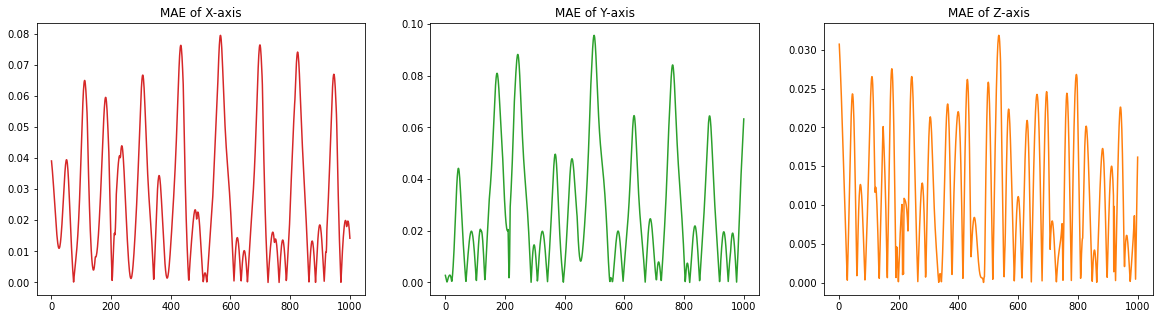

<Figure size 720x1440 with 0 Axes>

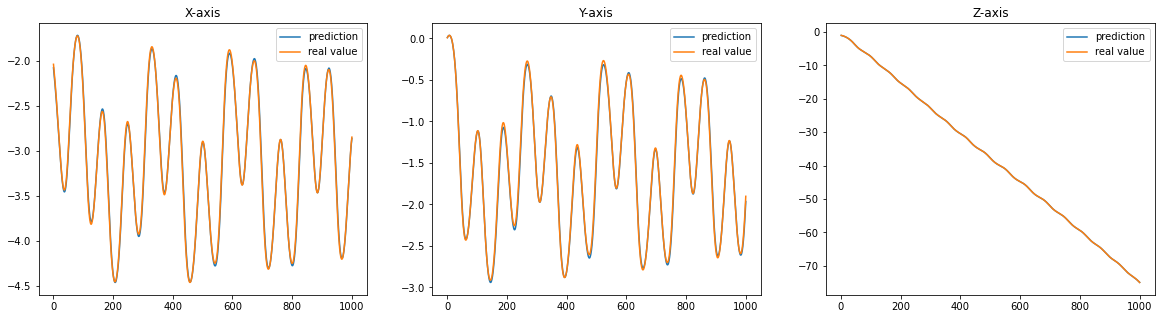

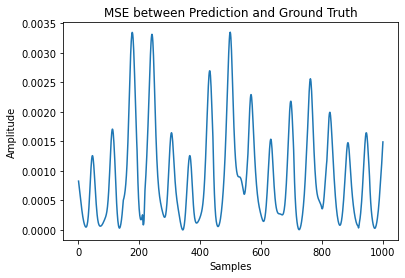

In [5]:
#task 2
#Execute the prediction of the model for 1000 points with same initial condition and
#plot the errors, that converge to zero
prediction = torch.zeros((1000,3))
err = torch.zeros((1000,3))
for i in range (1000):
    prediction[i] = best_model(X[i])
    if i ==3 :
        print(prediction[3][0])
    unormalize_output(prediction[i], maximum,minimum, vector = 'true')
    err[i] = Y[i] - prediction[i]

ERROR = torch.transpose(err,0,1)
e = ERROR.detach().numpy()
pred = (torch.transpose(prediction,0,1)).detach().numpy()

samples = np.linspace(1, 1000, 1000)
figure, axes = plt.subplots(nrows=1, ncols=3, figsize = (20,5))
plt.figure(figsize=(10,20))

axes[0].plot(samples, abs(e[0]), 'tab:red')
axes[0].set_title('MAE of X-axis')
axes[1].plot(samples, abs(e[1]), 'tab:green')
axes[1].set_title('MAE of Y-axis')
axes[2].plot(samples, abs(e[2]), 'tab:orange')
axes[2].set_title('MAE of Z-axis')

plt.show()

figure, axes = plt.subplots(nrows=1, ncols=3, figsize = (20,5))

axes[0].plot(samples, pred[0], label = 'prediction')
axes[0].plot(samples, Y_old[0], label = 'real value')
axes[0].set_title('X-axis')
axes[1].plot(samples, pred[1], label = 'prediction')
axes[1].plot(samples, Y_old[1], label = 'real value')
axes[1].set_title('Y-axis')
axes[2].plot(samples, pred[2], label = 'prediction')
axes[2].plot(samples, Y_old[2], label = 'real value')
axes[2].set_title('Z-axis')
axes[0].legend()
axes[1].legend()
axes[2].legend()
plt.show()

for ax in axes.flat:
    ax.set(xlabel='Samples', ylabel='Amplitude')

figure.tight_layout()

mse = np.zeros(1000)

for i in range(1000):
    mse[i] = mean_squared_error(Y[i].detach().numpy(), prediction[i].detach().numpy())
    
plt.plot(samples, mse)
plt.title("MSE between Prediction and Ground Truth")
plt.ylabel("Amplitude")
plt.xlabel("Samples")
plt.show()

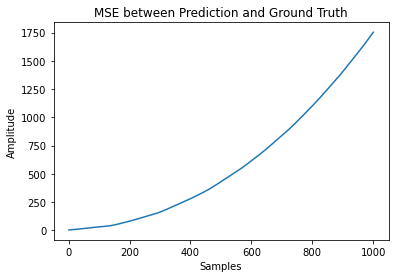

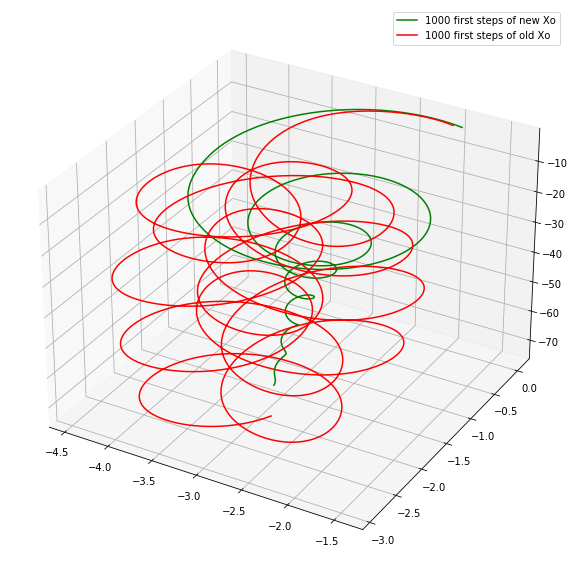

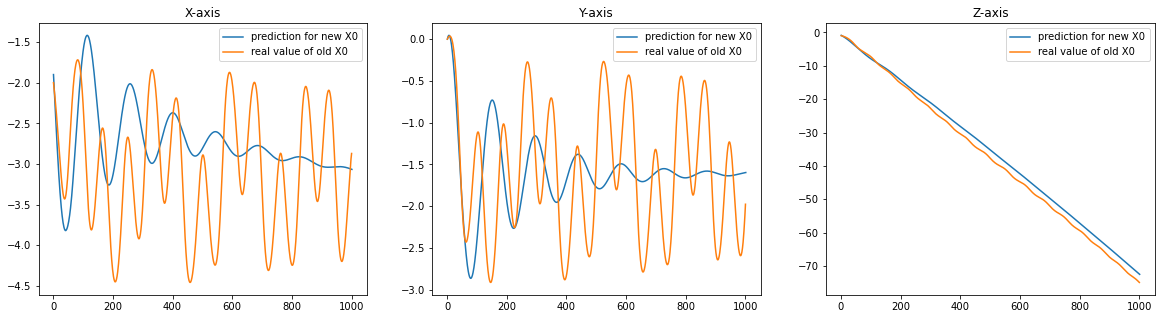

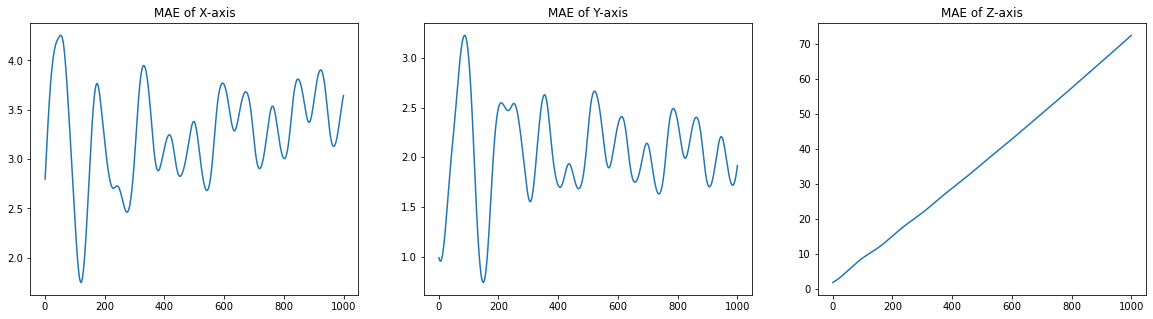

In [6]:
#task 3
#With different initial condition, plot the results for 1000 points
x_0 = torch.tensor([-1.9,0,-0.9])
steps = 1001

normalize_input(x_0, maximum,minimum, vector = 'true')
output = torch.zeros((steps,3))
output[0] = x_0.detach().clone()
for i in range (1,steps):    
    output[i] = best_model(output[i-1])

unormalize_output(output,maximum,minimum)

mse = np.zeros(steps-1)

for i in range(steps-1):
    mse[i] = mean_squared_error(X[i].detach().numpy(), output[i].detach().numpy())
    
samples = np.linspace(1, steps, steps)
samples1 = np.linspace(1, steps-1, steps-1)

plt.plot(samples1, mse)
plt.title("MSE between Prediction and Ground Truth")
plt.ylabel("Amplitude")
plt.xlabel("Samples")
plt.show()

x_val = (output.detach().numpy()).T

error = torch.zeros((steps-1,3))
for i in range(steps-1):
    error[i] = X[i] - output[i]

error = torch.transpose(error,0,1)

OUT = (torch.transpose(output, 0,1)).detach().numpy()

fig = plt.figure(figsize=(10,20))
ax = fig.gca(projection='3d')


# Data for a three-dimensional line 
ax.plot3D(OUT[0], OUT[1], OUT[2], 'green', label = '1000 first steps of new Xo')
ax.plot3D(X_old[0,:steps-1].detach().numpy(), X_old[1,:steps-1].detach().numpy(), X_old[2,:steps-1].detach().numpy(), 'red', 
          label = '1000 first steps of old Xo')
ax.legend()
plt.show()

figure, axes = plt.subplots(nrows=1, ncols=3, figsize = (20,5))



axes[0].plot(samples, OUT[0], label = 'prediction for new X0')
axes[0].plot(samples1, X_old[0,:steps-1].detach().numpy(), label = 'real value of old X0')
axes[0].set_title('X-axis')
axes[1].plot(samples, OUT[1], label = 'prediction for new X0')
axes[1].plot(samples1, X_old[1,:steps-1].detach().numpy(), label = 'real value of old X0')
axes[1].set_title('Y-axis')
axes[2].plot(samples, OUT[2], label = 'prediction for new X0')
axes[2].plot(samples1, X_old[2,:steps-1].detach().numpy(), label = 'real value of old X0')
axes[2].set_title('Z-axis')
axes[0].legend()
axes[1].legend()
axes[2].legend()

figure, axes = plt.subplots(nrows=1, ncols=3, figsize = (20,5))
axes[0].plot(samples1, abs(error[0].detach().numpy()))
axes[0].set_title('ΜΑΕ of X-axis')
axes[1].plot(samples1, abs(error[1].detach().numpy()))
axes[1].set_title('ΜΑΕ of Y-axis')
axes[2].plot(samples1, abs(error[2].detach().numpy()))
axes[2].set_title('MAE of Z-axis')
plt.show()

